In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral

from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
import winsound
import dill, wandb
import datetime as dt
wandblog=0
if wandblog:
    !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf
run_counter=0

Notebook
GPU detected


In [2]:
tf.__version__, spektral.__version__

('2.4.1', '1.0.3')

In [3]:
################################################
# Setup Deafult Variables                       # 
################################################
learning_rate = 5e-4
batch_size    = 512
epochs        = 20
n_data       = 1e4
scenario    = "GAT_test"+str(run_counter)
patience = 5

################################################
# Setup Hyperparameters                        # 
################################################
hidden_states = 'N/A'
forward       = False
dropout       = 'None'
loss_method   = "loss_func_linear_angle"
n_neighbors   = 6 # SKRIV SELV IND

In [4]:
################################################
# Load data                      # 
################################################
import data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=n_data, restart=1, transform=True, skip=0)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]

loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size) # the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)

winsound.Beep(400,300)

Removed and ready to reload
Connecting to db-file
Loading Muons
Reading files
Splitting data to events
   energy_log10  direction_x  direction_y  direction_z
0      2.311812    -0.865731     0.296605    -0.403157
1      3.433424     0.880773    -0.310683    -0.357373
2      2.582473    -0.100173     0.485243    -0.868622
3      2.783172    -0.297639     0.579176    -0.758924
4      2.531798    -0.523105     0.089420    -0.847565
Generating adjacency matrices


C:\Users\chris\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(



Saving dataset
Loading data to memory


In [5]:
# from evals import metricsxpos3 as metrics

# def test_angle(loader, plot=True):
#     '''Function to test and plot performance of Graph DL
#     input should be dom pos x,y,z , time, charge(log10)
#     target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
#     '''
#     loss = 0
#     prediction_list, target_list = [], []
#     for batch in loader:
#         inputs, targets = batch
#         inputs[0][:, :3] = inputs[0][:, :3] / 1000 #always pay attention to these two normalizations
#         predictions, targets, out = test_step(inputs, targets)
#         loss           += out
        
#         prediction_list.append(predictions)
#         target_list.append(targets)

#     y_reco  = tf.concat(prediction_list, axis = 0).numpy()
#     y_true  = tf.concat(target_list, axis = 0)
#     y_true  = tf.cast(y_true, tf.float32).numpy()

#     energy = y_true[:, 0]
#     counts, bins = np.histogram(energy, bins = 10)

#     xs = (bins[1:] + bins[: -1]) / 2

#     w_energies, u_angles = [], []

#     for i in range(len(bins)-1):
#         idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

#         w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

#         w_energies.append(w)
#         u_angles.append(u_angle)

#     if plot:
#         fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

#         for a in ax:
#             a_ = a.twinx()
#             a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
#             a_.set_yscale("log")
#             a.set_xlabel("Log Energy")
        
#         ax_top = ax

#         # Energy reconstruction
#         ax_top[0].scatter(xs, w_energies)
#         ax_top[0].set_title("Energy Performance")
#         ax_top[0].set_ylabel(r"$w(\Delta log(E)$")

#         # Angle reconstruction
#         ax_top[1].scatter(xs, u_angles)
#         ax_top[1].set_title("Angle Performance")
#         ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")

#         return fig, ax

In [6]:
if wandblog:
    #checks
    wandb.init(project="icecube", name=scenario,entity="chri862z")

    # Declare for log
    wandb.config.hidden_states = hidden_states
    wandb.config.hidden_states = n_data
    wandb.config.forward = forward
    wandb.config.dropout = dropout
    wandb.config.learning_rate = learning_rate
    wandb.config.batch_size = batch_size
    wandb.config.loss_func = loss_method
    wandb.config.n_neighbors = n_neighbors
    wandb.config.optimizer = 'Adam'

In [7]:
################################################
# Load Model and do checks                      # 
################################################
# import models.GCN0 as m
import models.GCN_johann as m
reload(m)
# model=m.GCN0(6)
model=m.model()
import evals as evals
reload(evals)
metrics=evals.metricsxpos3
# model.compile('adam', 'categorical_crossentropy') ## this is a basic setup with predetermined optimizers and so on

In [8]:
# ################################################
# # Setup functions                            # 
# ################################################
import loss.loss_funcs as loss_funcs
reload(loss_funcs)
loss_func=loss_funcs.loss_funcunit

def lr_schedule(epochs = epochs, initial = learning_rate, decay = 0.9):
    n = 1
    lr = initial
    yield lr
    while n < 3:
        lr *= 2
        n  += 1
        yield lr
    while True:
        lr *= decay
        n  += 1 
        yield lr


#make functions into tf functions
alist0 = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets, alist=alist0):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(predictions, targets)
        loss       += sum(model.losses)
#     alist=tf.concat(alist, alpha) 
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    out         = loss_func(predictions, targets)

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
#         inputs[0][:, 3] = inputs[0][:, 3] / 1000
        # targets[:, 1:4] = targets[:, 1:4] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)
    
    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)

    # w_energy, u_pos, u_angle = metrics(y_reco, y_true) #still missing something
    loss, losses = loss_func(y_reco, y_true, re=True)

    return loss, losses, metrics(y_reco, y_true)



opt = Adam(learning_rate)

In [9]:
run_counter+=1
k=0.2
tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
pbar0          = tqdm(total = epochs, position = 0, leave = True)
pbar0.set_description(f"Epochbar")
pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)
start_time    = time.time()
lr_gen        = lr_schedule(initial=learning_rate)
learning_Rate = next(lr_gen)
cwd = osp.abspath('')
save_path = osp.join(cwd, 'trained_models/'+scenario)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving '+scenario+' made')
# Implement saving model archictecture to wandb
for batch in loader_train:
    inputs, targets = batch
    inputs[0][:, :3] = inputs[0][:, :3] / 1000 #normalize position
#     inputs[0][:, 3] = inputs[0][:, 3] / 1000 #normalize time
    out             = train_step(inputs, targets)
    loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
    
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
    
    
    if current_batch == loader_train.steps_per_epoch:
        t=time.time() - start_time
        tot_time+=t
        print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
#         val_loss, val_loss_from, val_metric = validation(loader_val)
        val_loss, val_loss_from, val_metric = validation(loader_val)
        if wandblog:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                       "Validation Loss": val_loss, 
                       "Energy metric":   val_metric[0],
                       "Angle metric":    val_metric[1],
                       "Learning rate":   learning_rate})

        print(f"Avg loss of validation: {val_loss:.6f}")
        print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
        print(f"Energy: w = {val_metric[0]:.6f} \t Angle: u = {val_metric[1]:.6f}")

        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        print(f'Early stop counter: {early_stop_counter}/{patience}, lowest loss was {lowest_loss:.6f}')
        if early_stop and (early_stop_counter >= patience):
            model.save(save_path)
            print(f"Stopped training. No improvement was seen in {patience} epochs")
            break

        if current_epoch != epochs:
            pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)

        learning_rate = next(lr_gen)
        opt.learning_rate.assign(learning_rate)
        pbar0.update(1)
        time_avg=tot_time/current_epoch
        delta=dt.timedelta(seconds=time_avg*(epochs-current_epoch))
        now = dt.datetime.now()
        then=now+delta
        time_e = then.strftime("%H:%M:%S")
        pbar0.set_description(f"Expect to finish at {time_e}")
#         if current_epoch % 10 == 0:
#             model.save(save_path)
#             print("Model saved")

        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0
winsound.Beep(400,300)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ecc_conv (ECCConv)           multiple                  29696     
_________________________________________________________________
gcn_conv (GCNConv)           multiple                  4096      
_________________________________________________________________
gcn_conv_1 (GCNConv)         multiple                  8192      
_________________________________________________________________
gcn_conv_2 (GCNConv)         multiple                  32768     
_________________________________________________________________
gcn_conv_3 (GCNConv)         multiple                  131072    
_________________________________________________________________
global_max_pool (GlobalMaxPo multiple                  0         
_________________________________________________________________
global_avg_pool (GlobalAvgPo multiple                  0     

Epoch 2 of 20 done in 11.13 seconds using learning rate: 2.00E-04
Avg loss of train: 3.623509
[1000 3] [1000 3]
Avg loss of validation: 4.312655
Loss from:  Energy: 2.602915 	 Angle: 1.709741 
Energy: w = 0.330609 	 Angle: u = 128.735489
Early stop counter: 1/5, lowest loss was 3.055490


Epoch 3 of 20 done in 13.17 seconds using learning rate: 4.00E-04
Avg loss of train: 3.457915
[1000 3] [1000 3]
Avg loss of validation: 4.595119
Loss from:  Energy: 2.992236 	 Angle: 1.602883 
Energy: w = 0.632569 	 Angle: u = 125.357986
Early stop counter: 2/5, lowest loss was 3.055490


Epoch 4 of 20 done in 15.04 seconds using learning rate: 3.60E-04
Avg loss of train: 3.288037
[1000 3] [1000 3]
Avg loss of validation: 4.205562
Loss from:  Energy: 2.845999 	 Angle: 1.359562 
Energy: w = 0.577999 	 Angle: u = 101.334290
Early stop counter: 3/5, lowest loss was 3.055490


Epoch 5 of 20 done in 15.42 seconds using learning rate: 3.24E-04
Avg loss of train: 3.149001
[1000 3] [1000 3]
Avg loss of validation: 4.258471
Loss from:  Energy: 3.008071 	 Angle: 1.250401 
Energy: w = 0.929198 	 Angle: u = 86.293457
Early stop counter: 4/5, lowest loss was 3.055490


Epoch 6 of 20 done in 13.30 seconds using learning rate: 2.92E-04
Avg loss of train: 3.019034
[1000 3] [1000 3]
Avg loss of validation: 4.390513
Loss from:  Energy: 3.181934 	 Angle: 1.208580 
Energy: w = 1.042107 	 Angle: u = 77.033134
Early stop counter: 5/5, lowest loss was 3.055490







INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models/GAT_test0\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\trained_models/GAT_test0\assets


Stopped training. No improvement was seen in 5 epochs


In [10]:

for batch in loader_test:
    inputs, targets = batch
    inputs[0][:, :3] = inputs[0][:, :3] / 1000#normalize position
    predictions=model(inputs, training = False)
    print('lol')

lol
lol


(array([ 14.,  58., 126., 141.,  71.,  40.,  23.,   7.,   5.,   3.]),
 array([1.83661235, 2.04767451, 2.25873667, 2.46979884, 2.680861  ,
        2.89192316, 3.10298533, 3.31404749, 3.52510966, 3.73617182,
        3.94723398]),
 <BarContainer object of 10 artists>)

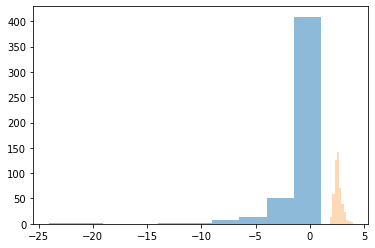

In [15]:
plt.hist(predictions[:,0].numpy(), bins=10, alpha=0.5)
plt.hist(targets[:,0], bins=10, alpha=0.3)

(array([21., 50., 45., 58., 81., 69., 62., 49., 39., 14.]),
 array([-0.95910376, -0.76624785, -0.57339194, -0.38053603, -0.18768012,
         0.00517579,  0.1980317 ,  0.39088761,  0.58374352,  0.77659943,
         0.96945534]),
 <BarContainer object of 10 artists>)

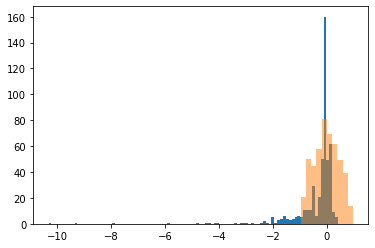

In [18]:
plt.hist(predictions[:,1].numpy(), bins=100)
plt.hist(targets[:,1], bins=10, alpha=0.5)

(array([424.,  36.,  13.,   7.,   2.,   1.,   3.,   0.,   1.,   1.]),
 array([-1.2890164,  2.9558837,  7.2007837, 11.4456835, 15.690584 ,
        19.935484 , 24.180384 , 28.425283 , 32.670185 , 36.915085 ,
        41.159985 ], dtype=float32),
 <BarContainer object of 10 artists>)

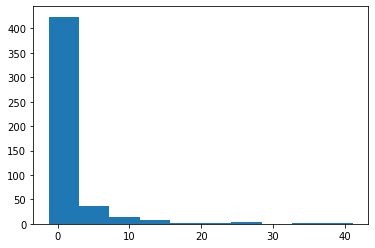

In [19]:
plt.hist(predictions[:,3].numpy(), bins=10)
# plt.hist(target[], bins=10)

In [14]:
fig, ax = test_angle(loader_test)
if wandblog:
    fig.savefig(f"model_tests/{scenario}_test.pdf")

NameError: name 'test_angle' is not defined

In [ ]:
################################################
# Evaluating our model                 # 
################################################

trainable_count = int(
    np.sum([K.count_params(p) for p in model.trainable_weights]))
non_trainable_count = int(
    np.sum([K.count_params(p) for p in model.non_trainable_weights]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))